<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set Plot Stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

*Parameters:*

    ticker: String that specifies the trading ticker of the equity 
    startData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp
    endData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker


*Resources:*
*   [Dataframe.shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)



In [3]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    # Difference if based on 'close' price
    df['diff'] = df['close'].diff()
    df['change'] = df['diff'] / df['close'].shift(periods=1) * 100
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Creating Dataframe with stock data

In [4]:
ticker = 'QQQ'
endDate = datetime.now().strftime('%s')
startDate = datetime(year=2009, month=1, day=1, hour=0, minute=0).strftime('%s')

df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

# Plotting QQQ open prices from January 1, 2009 to the current day using Unix Timestamps

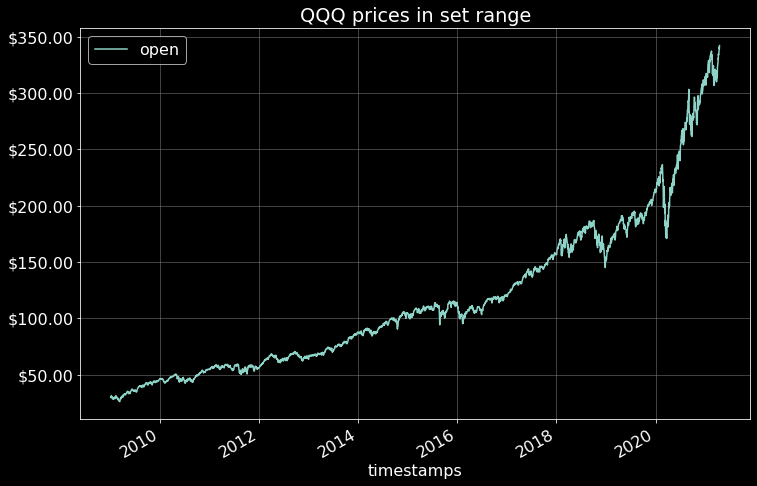

In [5]:
ax = df.plot(x='timestamps', y=['open'], kind='line', title=ticker + ' prices in set range')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

# Showing Dataframe head

In [6]:
df.head()

,timestamps,open,high,low,close,volume,diff,change
0,2009-01-02 14:30:00,29.750000,31.129999,29.690001,31.030001,107891500,NaN,NaN
1,2009-01-05 14:30:00,30.830000,31.330000,30.590000,31.020000,91751900,-0.010000,-0.032228
2,2009-01-06 14:30:00,31.250000,31.629999,31.110001,31.330000,136791700,0.309999,0.999354
3,2009-01-07 14:30:00,30.730000,30.900000,30.190001,30.440001,133879800,-0.889999,-2.840726
4,2009-01-08 14:30:00,30.379999,30.799999,30.080000,30.760000,131926600,0.320000,1.051247


# Creating Training Data

In [86]:
training_data = df[df['timestamps']<'2020-01-01'].copy()
training_data = training_data.drop(['timestamps'], axis=1)
training_data = training_data.iloc[1:]    # Drops first row in dataframe
training_data.head() 

,open,high,low,close,volume,diff,change
1,30.830000,31.330000,30.590000,31.020000,91751900,-0.010000,-0.032228
2,31.250000,31.629999,31.110001,31.330000,136791700,0.309999,0.999354
3,30.730000,30.900000,30.190001,30.440001,133879800,-0.889999,-2.840726
4,30.379999,30.799999,30.080000,30.760000,131926600,0.320000,1.051247
5,30.770000,30.790001,29.920000,30.070000,117137900,-0.690001,-2.243175


# Using z-score standardization

(array([  1.,   0.,   0.,   0.,   2.,   2.,   2.,   3.,   5.,   2.,   8.,
         13.,  14.,  13.,  30.,  24.,  27.,  41.,  66.,  73.,  85., 133.,
        178., 304., 362., 349., 270., 226., 156., 113.,  84.,  47.,  38.,
         27.,  14.,  14.,  10.,   9.,   7.,   5.,   0.,   3.,   1.,   0.,
          1.,   2.,   0.,   0.,   1.,   2.]),
 array([-5.33182182, -5.11727667, -4.90273151, -4.68818636, -4.4736412 ,
        -4.25909605, -4.0445509 , -3.83000574, -3.61546059, -3.40091544,
        -3.18637028, -2.97182513, -2.75727997, -2.54273482, -2.32818967,
        -2.11364451, -1.89909936, -1.6845542 , -1.47000905, -1.2554639 ,
        -1.04091874, -0.82637359, -0.61182844, -0.39728328, -0.18273813,
         0.03180703,  0.24635218,  0.46089733,  0.67544249,  0.88998764,
         1.10453279,  1.31907795,  1.5336231 ,  1.74816826,  1.96271341,
         2.17725856,  2.39180372,  2.60634887,  2.82089402,  3.03543918,
         3.24998433,  3.46452949,  3.67907464,  3.89361979,  4.10816495,
 

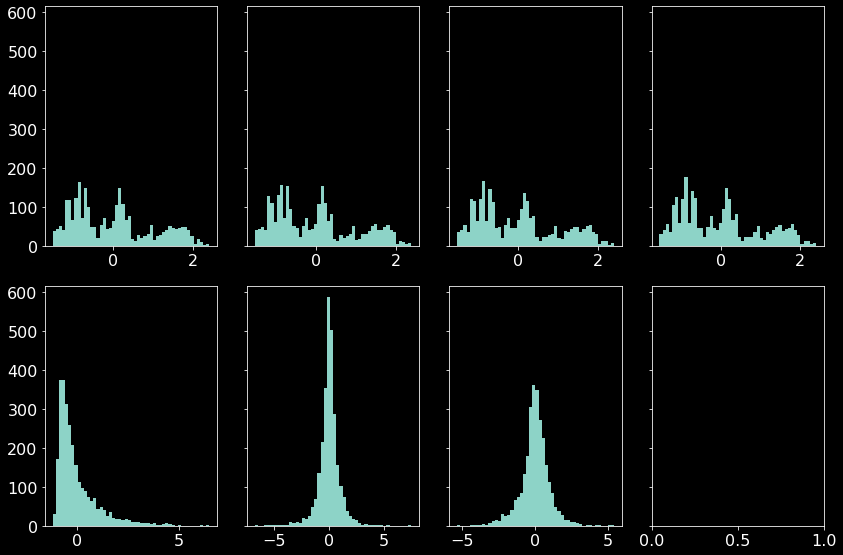

In [87]:
from scipy import stats

training_data = stats.zscore(training_data, axis=0, ddof=0, nan_policy='omit')

n_bins = 50

fig, axs = plt.subplots(2, 4, sharey=True, tight_layout=True)
axs[0][0].hist(training_data[:, 0], bins=n_bins)
axs[0][1].hist(training_data[:, 1], bins=n_bins)
axs[0][2].hist(training_data[:, 2], bins=n_bins)
axs[0][3].hist(training_data[:, 3], bins=n_bins)
axs[1][0].hist(training_data[:, 4], bins=n_bins)
axs[1][1].hist(training_data[:, 5], bins=n_bins)
axs[1][2].hist(training_data[:, 6], bins=n_bins)

# Import needed Keras components

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool1D, Activation

# Build CNN-LSTM model

In [ ]:
model = Sequential([
    Conv1D(filters=32, 
           kernel_size=1, 
           padding='same', 
           activation='tanh', 
           input_shape=(10, 8)),
    MaxPool1D(pool_size=1, padding='same'),
    Activation('relu'),
    LSTM(units=64, 
         activation='relu', 
         input_shape=(10, 32)),
    Dense(units=1) # Should I use a kernel initializer?
])

# Show summary of model

In [ ]:
model.summary()

# Compiling model

In [ ]:
from tensorflow.keras import optimizers

learning_rate = 0.001

optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Fitting model

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=64)